In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


In [ ]:
import kagglehub
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Download dataset
path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")
print("Path to dataset files:", path)

# Load CSV
df = pd.read_csv(os.path.join(path, 'english.csv'))
print(df["label"])

Using Colab cache for faster access to the 'english-handwritten-characters-dataset' dataset.
Path to dataset files: /kaggle/input/english-handwritten-characters-dataset
0       0
1       0
2       0
3       0
4       0
       ..
3405    z
3406    z
3407    z
3408    z
3409    z
Name: label, Length: 3410, dtype: object


In [ ]:
img_size = 64  # resize to fixed size
X = []
y = []

for i, row in df.iterrows():
    fil = row['image']
    label = row['label']
    img_path = os.path.join(path, fil)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)
        y.append(label)

X = np.array(X, dtype="float32") / 255.0   # normalize safely
X = X.reshape(-1, img_size * img_size)     # flatten after scaling

y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3410, 4096)
y shape: (3410,)


In [ ]:
print("Before normalization:")
print("min:", img.min(), "max:", img.max(), "unique:", np.unique(img)[:10])


Before normalization:
min: 0 max: 255 unique: [  0 120 178 183 204 215 224 242 255]


In [ ]:
print("X min:", X.min(), "X max:", X.max(), "X unique:", np.unique(X)[:10])


X min: 0.0 X max: 1.0 X unique: [0.         0.00392157 0.01176471 0.01960784 0.02745098 0.03137255
 0.03529412 0.04313726 0.05098039 0.05882353]


In [ ]:
from collections import Counter
print(Counter(y))


Counter({np.str_('0'): 55, np.str_('1'): 55, np.str_('2'): 55, np.str_('3'): 55, np.str_('4'): 55, np.str_('5'): 55, np.str_('6'): 55, np.str_('7'): 55, np.str_('8'): 55, np.str_('9'): 55, np.str_('A'): 55, np.str_('B'): 55, np.str_('C'): 55, np.str_('D'): 55, np.str_('E'): 55, np.str_('F'): 55, np.str_('G'): 55, np.str_('H'): 55, np.str_('I'): 55, np.str_('J'): 55, np.str_('K'): 55, np.str_('L'): 55, np.str_('M'): 55, np.str_('N'): 55, np.str_('O'): 55, np.str_('P'): 55, np.str_('Q'): 55, np.str_('R'): 55, np.str_('S'): 55, np.str_('T'): 55, np.str_('U'): 55, np.str_('V'): 55, np.str_('W'): 55, np.str_('X'): 55, np.str_('Y'): 55, np.str_('Z'): 55, np.str_('a'): 55, np.str_('b'): 55, np.str_('c'): 55, np.str_('d'): 55, np.str_('e'): 55, np.str_('f'): 55, np.str_('g'): 55, np.str_('h'): 55, np.str_('i'): 55, np.str_('j'): 55, np.str_('k'): 55, np.str_('l'): 55, np.str_('m'): 55, np.str_('n'): 55, np.str_('o'): 55, np.str_('p'): 55, np.str_('q'): 55, np.str_('r'): 55, np.str_('s'): 55, n

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded_onehot = to_categorical(y_encoded)
num_classes = y_encoded_onehot.shape[1]

print("Classes:", le.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)


Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
print("X_train min:", X_train.min())
print("X_train max:", X_train.max())
print("Unique values in X_train:", np.unique(X_train)[:20])


X_train min: 0.0
X_train max: 1.0
Unique values in X_train: [0.         0.00392157 0.01176471 0.01960784 0.02745098 0.03137255
 0.03529412 0.04313726 0.05098039 0.05882353 0.06666667 0.07450981
 0.08235294 0.09019608 0.09411765 0.09803922 0.10588235 0.11372549
 0.12156863 0.1254902 ]


In [ ]:
class PLA:
    def __init__(self, input_dim, num_classes, lr=0.01, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.num_classes = num_classes
        self.W = np.zeros((input_dim, num_classes))
        self.b = np.zeros(num_classes)

    def step_function(self, z):
        return (z > 0).astype(int)

    def fit(self, X, y):
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                xi = X[i]
                target = np.argmax(y[i])
                scores = np.dot(xi, self.W) + self.b
                y_hat = np.argmax(scores)
                if y_hat != target:
                    self.W[:, target] += self.lr * xi
                    self.W[:, y_hat] -= self.lr * xi
            print(f"Epoch {epoch+1}/{self.epochs} completed")

    def predict(self, X):
        scores = np.dot(X, self.W) + self.b
        return np.argmax(scores, axis=1)


pla = PLA(input_dim=X_train.shape[1], num_classes=num_classes, lr=0.01, epochs=5)
pla.fit(X_train, y_train)

y_pred_pla = pla.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print("PLA Classification Report:")
print(classification_report(y_true, y_pred_pla, target_names=le.classes_.astype(str)))


Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed
PLA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        11
           2       0.33      0.09      0.14        11
           3       0.00      0.00      0.00        11
           4       0.17      0.09      0.12        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.24      0.73      0.36        11
           A       0.00      0.00      0.00        11
           B       0.00      0.00      0.00        11
           C       0.00      0.00      0.00        11
           D       0.50      0.09      0.15        11
           E       0.00      0.00      0.00        11
        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(X_train)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


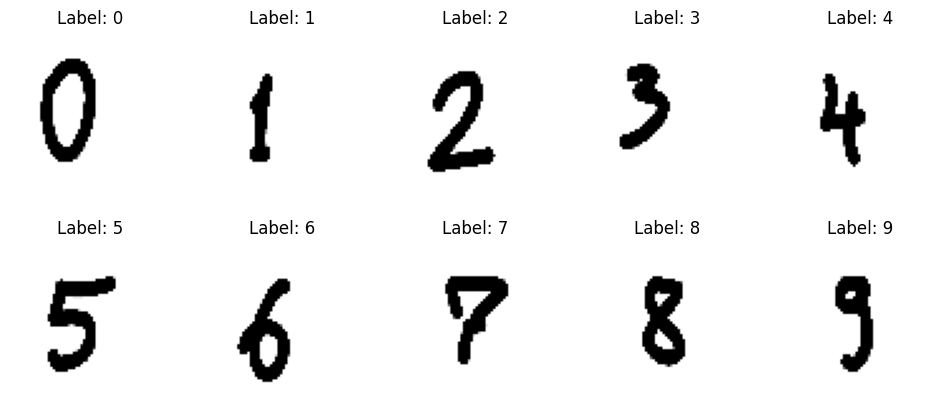

In [ ]:
classes_to_show = np.unique(y)[:10]  # pick 10 different classes
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for idx, cls in enumerate(classes_to_show):
    i = np.where(y == cls)[0][0]  # find first index of that class
    ax = axes.flat[idx]
    ax.imshow(X[i].reshape(img_size, img_size), cmap="gray")
    ax.set_title(f"Label: {cls}")
    ax.axis("off")

plt.show()


In [ ]:
print("y_train shape before one-hot:", y_train.shape)
print("Unique labels:", np.unique(y_train[:20]))


y_train shape before one-hot: (2728, 62)
Unique labels: [0. 1.]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

# Flatten input if image shaped
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

activation_functions = ['relu', 'tanh']
# Define optimizers as callables (not pre-built instances)
optimizers = {
    "SGD": lambda: SGD(learning_rate=0.01, momentum=0.9),
    "Adam": lambda: Adam(learning_rate=0.001),
    "RMSprop": lambda: RMSprop(learning_rate=0.001),
}

results = {}

for act_func in activation_functions:
    for opt_name, opt_fn in optimizers.items():
        print(f"\n🔹 Training MLP with activation={act_func} and optimizer={opt_name}")

        model = Sequential([
            Input(shape=(X_train.shape[1],)),   # ✅ cleaner than input_shape in Dense
            Dense(512, activation=act_func),
            Dropout(0.3),
            Dense(256, activation=act_func),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

        # ✅ fresh optimizer instance
        optimizer = opt_fn()

        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=20,
            batch_size=64,
            verbose=1
        )

        results[(act_func, opt_name)] = history.history



🔹 Training MLP with activation=relu and optimizer=SGD
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0122 - loss: 4.4467 - val_accuracy: 0.0205 - val_loss: 4.1313
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0165 - loss: 4.1437 - val_accuracy: 0.0132 - val_loss: 4.1269
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.0143 - loss: 4.1277 - val_accuracy: 0.0161 - val_loss: 4.1272
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0129 - loss: 4.1279 - val_accuracy: 0.0161 - val_loss: 4.1272
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.0149 - loss: 4.1276 - val_accuracy: 0.0161 - val_loss: 4.1272
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0190 - loss: 4.1287 - val_accuracy: 0.0161 - val_loss: 4.1272
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.0173 - loss: 4.1276 - val_accuracy: 0.0161 - val_loss: 4.1272
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc

In [ ]:
import kagglehub
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam

# Download dataset
path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")
print("Path to dataset files:", path)

# Load CSV
df = pd.read_csv(os.path.join(path, 'english.csv'))
print(df.head())

img_size = 64  # resize to fixed size
X = []
y = []

for i, row in df.iterrows():
    fil = row['image']
    label = row['label']
    img_path = os.path.join(path, fil)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Flatten and normalize for PLA/MLP
X_flat = X.reshape(-1, img_size * img_size) / 255.0

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded_onehot = to_categorical(y_encoded)
num_classes = y_encoded_onehot.shape[1]

print("Classes:", le.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# PLA Classifier
class PLA:
    def __init__(self, input_dim, num_classes, lr=0.01, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.num_classes = num_classes
        self.W = np.zeros((input_dim, num_classes))
        self.b = np.zeros(num_classes)

    def fit(self, X, y):
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                xi = X[i]
                target = np.argmax(y[i])
                scores = np.dot(xi, self.W) + self.b
                y_hat = np.argmax(scores)
                if y_hat != target:
                    self.W[:, target] += self.lr * xi
                    self.W[:, y_hat] -= self.lr * xi
            print(f"Epoch {epoch+1}/{self.epochs} completed")

    def predict(self, X):
        scores = np.dot(X, self.W) + self.b
        return np.argmax(scores, axis=1)

print("\n===== Perceptron Learning Algorithm (PLA) =====")
pla = PLA(input_dim=X_train.shape[1], num_classes=num_classes, lr=0.01, epochs=5)
pla.fit(X_train, y_train)

y_pred_pla = pla.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print("\nPLA Classification Report:")
print(classification_report(y_true, y_pred_pla, target_names=le.classes_.astype(str), zero_division=0))


# MLP systematic training and evaluation
print("\n===== Multi-Layer Perceptron (MLP) Training =====")
tf.config.run_functions_eagerly(True)

# Hyperparameters
activations = ['relu', 'sigmoid', 'tanh']
optimizers = {
    'sgd_0.01': SGD(learning_rate=0.01),
    'sgd_0.001': SGD(learning_rate=0.001),
    'adam_0.01': Adam(learning_rate=0.01),
    'adam_0.001': Adam(learning_rate=0.001)
}

results = []

for act in activations:
    for opt_name, opt in optimizers.items():
        print(f"\nTraining MLP with activation={act}, optimizer={opt_name}...")

        # Build model
        mlp = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(256, activation=act),
            Dropout(0.3),
            Dense(128, activation=act),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

        mlp.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        # Train
        history = mlp.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=20,
            batch_size=64,
            verbose=0
        )

        # Evaluate
        test_loss, test_acc = mlp.evaluate(X_test, y_test, verbose=0)

        # Predictions
        y_pred = mlp.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)

        report = classification_report(
            y_true, y_pred_classes,
            target_names=le.classes_.astype(str),
            zero_division=0,
            output_dict=True
        )

        results.append({
            'activation': act,
            'optimizer': opt_name,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_f1': report['weighted avg']['f1-score']
        })

# Put results in DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='test_acc', ascending=False)

print("\n===== All Results =====")
print(results_df)

Using Colab cache for faster access to the 'english-handwritten-characters-dataset' dataset.
Path to dataset files: /kaggle/input/english-handwritten-characters-dataset
                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0
X shape: (3410, 64, 64)
y shape: (3410,)
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
X_train shape: (2728, 4096)
X_test shape: (682, 4096)
y_train shape: (2728, 62)
y_test shape: (682, 62)

===== Perceptron Learning Algorithm (PLA) =====
Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed

PLA Classification Report:
              precision    recall  f1-score   support

           0       0.00 

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Training MLP with activation=relu, optimizer=sgd_0.001...


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Training MLP with activation=relu, optimizer=adam_0.01...


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Training MLP with activation=relu, optimizer=adam_0.001...


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Training MLP with activation=sigmoid, optimizer=sgd_0.01...


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Unknown variable: <Variable path=sequential_33/dense_99/kernel, shape=(4096, 256), dtype=float32, value=[[-0.03475494 -0.00132901  0.02166515 ... -0.01036663  0.00619852
   0.01706775]
 [ 0.00657668  0.00020749 -0.03616791 ...  0.03207246  0.02842291
   0.00177043]
 [ 0.03224905  0.00221035  0.01544712 ... -0.00378673  0.03094978
  -0.02744707]
 ...
 [-0.03215418 -0.01920486 -0.01611332 ...  0.00857177 -0.01570316
  -0.01311625]
 [-0.01956653  0.02416939  0.03698403 ...  0.00999744 -0.03592919
   0.02028155]
 [-0.00641564 -0.03170066 -0.0007044  ...  0.02929342 -0.03093882
   0.03491192]]>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
!apt-get install pandoc -y

!jupyter nbconvert --to latex "/content/drive/MyDrive/Colab_Notebooks/ML_Assignment5.ipynb"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/ML_Assignment5.ipynb to latex
[NbConvertApp] Support files will be in ML_Assignment5_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Colab_Notebooks/ML_Assignment5_files
[NbConvertApp] Writing 111465 bytes to /content/drive/MyDrive/Colab_Notebooks/ML_Assignment5.tex


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab_Notebooks/ML_Assignment5.tex')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>